In [1]:
'''
THIS NOTEBOOK'S QUESTION:
Why and how will we divide these 20K rows into TRAINING (80%) vs TESTING (20%)?

DATA LEAKAGE:
If we clean the data before splitting, the eventual TESTING data will inform/bias the TRAINING data, likely making the results too clean
'''

"\nTHIS NOTEBOOK'S QUESTION:\nWhy and how will we divide these 20K rows into TRAINING (80%) vs TESTING (20%)?\n\nDATA LEAKAGE:\nIf we clean the data before splitting, the eventual TESTING data will inform/bias the TRAINING data, likely making the results too clean\n"

In [2]:
import os
import pandas #required to convert into a DataFrame

PROJECT_FILE_PATH = os.path.join("datasets", "housing")
csv_path = os.path.join(PROJECT_FILE_PATH, "housing.csv")
housing_dataframe = pandas.read_csv(csv_path)

In [3]:
# to split the dataset in an unbiased way, we want to use randoomized hash values
# but we want the hash values to come from a consistent source, so we are using STABLE position values from longitude/latitude

housing_dataframe["concatenated_position"] = (
    housing_dataframe["longitude"].astype(str) + "_" + housing_dataframe["latitude"].astype(str)
)

In [4]:
# create a hash value rooted in "concatenated_position"
from zlib import crc32
housing_dataframe["position_hash"] = housing_dataframe["concatenated_position"].apply(lambda x: crc32(x.encode()))

In [5]:
#split the data into training (80%) and testing (20%)
from sklearn.model_selection import train_test_split
train_dataframe, test_dataframe = train_test_split(housing_dataframe, test_size=0.2, random_state=42) #using a common utility from scikit package
train_dataframe.head() #this will give us a demonstration of the data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,concatenated_position,position_hash
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,-117.03_32.71,4083494086
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,-118.16_33.77,3441662498
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,-120.48_34.66,2885873792
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,-117.11_32.69,3213919234
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,-119.8_36.78,582164530


In [6]:
train_csv_path = os.path.join(PROJECT_FILE_PATH, "training80.csv")
test_csv_path = os.path.join(PROJECT_FILE_PATH, "testing20.csv")

train_dataframe.to_csv(train_csv_path, index=False)
print(f"Training data saved to {train_csv_path}")

train_dataframe.to_csv(test_csv_path, index=False)
print(f"Testing data saved to {test_csv_path}")

'''
We just verified that:
1. the training set has 80% a.k.a. 16,512 rows
2. the testing set has 20% a.k.a. 4,128 rows
3. both sets were saved as CSVs in correct folder

However, the downside with using that as that the computer may have weighted the data in the wrong portions expected by something like median income

'''

train_dataframe.describe() # write down the mean longitude here, and compare it to what you see later in stratified sample

Training data saved to datasets\housing\training80.csv
Testing data saved to datasets\housing\testing20.csv


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,position_hash
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,1.651200e+04
mean,-119.582290,35.643149,28.608285,2642.004784,538.496851,1426.453004,499.986919,3.880754,207194.693738,2.153645e+09
std,2.005654,2.136665,12.602499,2174.646744,419.007096,1137.056380,380.967964,1.904294,115622.626448,1.241851e+09
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000e+00
25%,-121.810000,33.930000,18.000000,1454.000000,296.750000,789.000000,280.000000,2.566700,119800.000000,1.085907e+09
50%,-118.510000,34.260000,29.000000,2129.000000,437.000000,1167.000000,410.000000,3.545800,179850.000000,2.150021e+09
75%,-118.010000,37.720000,37.000000,3160.000000,647.000000,1726.000000,606.000000,4.773175,265125.000000,3.243765e+09
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.294403e+09


<Axes: >

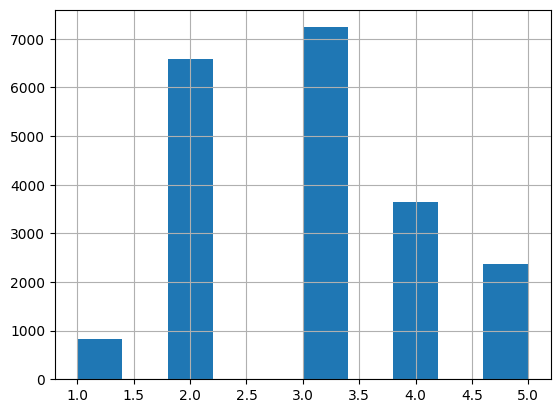

In [7]:
#begin stratified sampling (according to median income)
import pandas
import numpy

#creating a new "income_cat" for banding
housing_dataframe["income_cat"] = pandas.cut(
    housing_dataframe["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., numpy.inf],
    labels=[1, 2, 3, 4, 5]
)

#display function
housing_dataframe["income_cat"].hist()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # we only split once, test_size is a reserved term
for train_index, test_index in split.split(housing_dataframe, housing_dataframe["income_cat"]):
    strat_train_set = housing_dataframe.loc[train_index]
    strat_test_set = housing_dataframe.loc[test_index]

strat_train_set.describe() #take note that the mean longitude differs from the 1 in non-stratified(random) sample, suggesting it worked

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,position_hash
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,1.651200e+04
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,2.145696e+09
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,1.240325e+09
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.000000e+00
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,1.078540e+09
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,2.140086e+09
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,3.236559e+09
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,4.293965e+09


In [9]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [10]:
# eyeballing this, the similarities in distribution between training vs test data shows stratification worked
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [11]:
# even though .decribe doesnt show, there was an extra column used as a reference for stratification
print(strat_train_set.columns)
print(strat_test_set.columns)

for set_ in (strat_train_set, strat_test_set):
    try:
        set_.drop("income_cat", axis=1, inplace=True)
        print("\n wiped dimension: income_cat \n")
    except:
        pass
        
print(strat_train_set.columns)
print(strat_test_set.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'concatenated_position',
       'position_hash', 'income_cat'],
      dtype='object')
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'concatenated_position',
       'position_hash', 'income_cat'],
      dtype='object')

 wiped dimension: income_cat 


 wiped dimension: income_cat 

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'concatenated_position',
       'position_hash'],
      dtype='object')
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_i

In [12]:
# save as CSVs so other notebooks can import
strat_train_csv_path = os.path.join(PROJECT_FILE_PATH, "stratified_training_80.csv")
strat_test_csv_path = os.path.join(PROJECT_FILE_PATH, "stratified_testing_20.csv")

strat_train_set.to_csv(strat_train_csv_path, index=False)
print(f"Stratified training data saved to {strat_train_csv_path}")

strat_test_set.to_csv(strat_test_csv_path, index=False)
print(f"Stratified testing data saved to {strat_test_csv_path}")

Stratified training data saved to datasets\housing\stratified_training_80.csv
Stratified testing data saved to datasets\housing\stratified_testing_20.csv
